# Сборный проект —2

**Описание проета**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

**Задачи**

1. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Задача 1: предсказание уровня удовлетворённости сотрудника**

Для этой задачи заказчик предоставил данные с признаками:

`id` — уникальный идентификатор сотрудника;

`dept` — отдел, в котором работает сотрудник;

`level` — уровень занимаемой должности;

`workload` — уровень загруженности сотрудника;

`employment_years` — длительность работы в компании (в годах);

`last_year_promo` — показывает, было ли повышение за последний год;

`last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;

`supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;

`salary` — ежемесячная зарплата сотрудника;

`job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

**Задача 2: предсказание увольнения сотрудника из компании**

Для этой задачи используется те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это `quit` — увольнение сотрудника из компании.

**Общий план работы для двух задач:**
1. Загрузка данных.
2. Предобработка данных.
3. Исследовательский анализ данных.
4. Подготовка данных.
5. Обучение моделей.
6. Оформление выводов.

# Задача 1: предсказание уровня удовлетворённости сотрудникаЗадача 1: предсказание уровня удовлетворённости сотрудника

## Загрузка данных

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import phik
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score, make_scorer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE=42

In [3]:
train_job_satisfaction = pd.read_csv(r'~/train_job_satisfaction_rate.csv')
test_features = pd.read_csv(r'~/test_features.csv')
test_target_job_satisfaction = pd.read_csv(r'~/test_target_job_satisfaction_rate.csv')

In [4]:
train_job_satisfaction.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


In [5]:
train_job_satisfaction.info()
display(train_job_satisfaction.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


Данные выглядят чистыми, без пропусков. 

In [6]:
test_features.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


In [7]:
test_features.info()
display(test_features.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


Есть несколько пропусков в `dept` и `level`

In [8]:
test_target_job_satisfaction.head(10)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


In [9]:
test_target_job_satisfaction.info()
display(test_target_job_satisfaction.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


Здесь тоже все хорошо.

**Вывод:** данные хорошие, только есть несколько пропусков в датасете test_features.

## Предобработка данных

Столбцы уже приведены к змеиному регистру, типы данных соответствует нужному, проверим на дубликаты.

In [10]:
print('Количество дубликатов в train_job_satisfaction: ', train_job_satisfaction.duplicated().sum())
print('Количество дубликатов в test_features: ', test_features.duplicated().sum())
print('Количество дубликатов в test_target_job_satisfaction: ', test_target_job_satisfaction.duplicated().sum())

Количество дубликатов в train_job_satisfaction:  0
Количество дубликатов в test_features:  0
Количество дубликатов в test_target_job_satisfaction:  0


In [11]:
train_job_satisfaction[train_job_satisfaction.duplicated(
    subset=['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 
            'last_year_violations', 'supervisor_evaluation','salary', 'job_satisfaction_rate'])]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
437,302957,purchasing,junior,low,1,no,no,4,15600,0.61
502,752399,sales,middle,low,7,no,no,4,28800,0.77
520,802286,sales,junior,medium,1,no,no,4,21600,0.43
676,167303,sales,junior,medium,1,no,no,3,24000,0.34
784,191841,sales,junior,medium,1,no,no,5,21600,0.44
...,...,...,...,...,...,...,...,...,...,...
3969,737303,sales,middle,medium,3,no,no,4,33600,0.47
3984,281204,technology,junior,low,2,no,no,4,15600,0.68
3989,261436,sales,middle,low,3,no,no,3,22800,0.18
3995,457950,technology,junior,high,2,no,no,3,46800,0.45


Без id присутствуют 245 дубликатов. Не будем трогать, так как датасет небольшой.

In [12]:
train_job_satisfaction.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Обработаем пропуски в пайплайне.

**Вывод**: В данных обнаружены дубликаты. Их не обрабатывали, пока возьмем на заметку.

## Исследовательский анализ данных

Построим функции для построения графиков.

In [28]:
def cat_plot(df, column):
    display(df[column].unique())
    plt.figure(figsize=(9,7))
    sns.countplot(y=column, data=df)
    plt.title(f'Рапределение по {column}', fontsize=16)
    plt.xlabel('Количество', fontsize=14)

In [29]:
def hist_plot(df, column):
    display(df[column].unique())
    plt.figure(figsize=(9,7))
    sns.histplot(y=column, data=df)
    plt.title(f'Рапределение по {column}', fontsize=16)
    plt.xlabel('Количество', fontsize=14)

Будем сразу строить признаки из двух датасетов и сранивать.

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

None

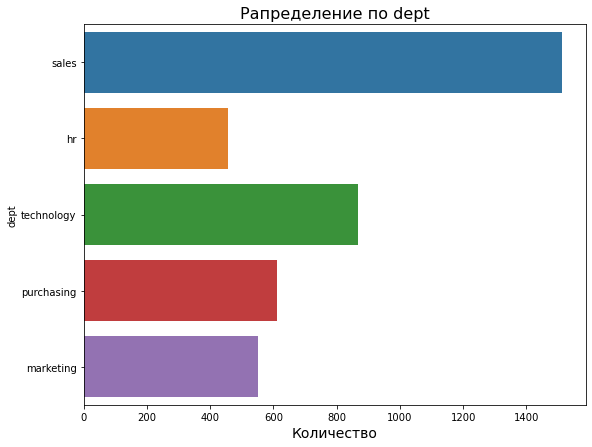

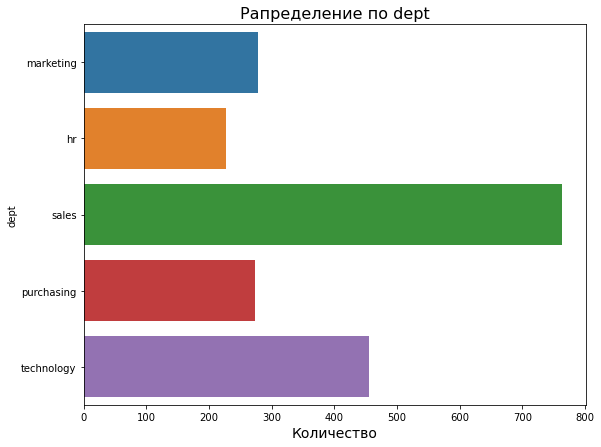

In [30]:
cat_plot(train_job_satisfaction, 'dept')
display(cat_plot(test_features, 'dept'))

Видим, что `sales`является преобладающим. Ага, у нас есть данные в виде " ". Нужно это обработать.

In [31]:
test_features['dept'] = test_features['dept'].replace(' ', np.nan)

array(['junior', 'middle', 'sinior', nan], dtype=object)

array(['junior', 'middle', 'sinior', nan], dtype=object)

None

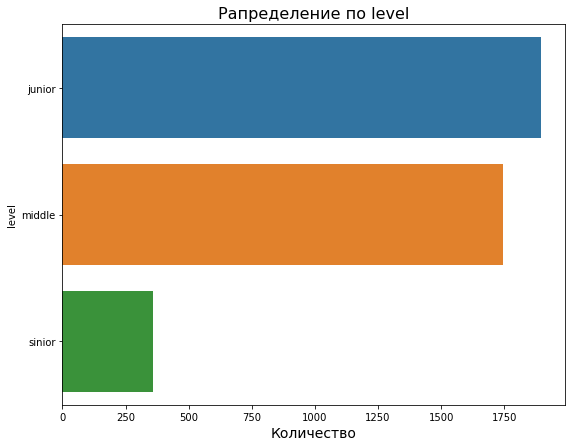

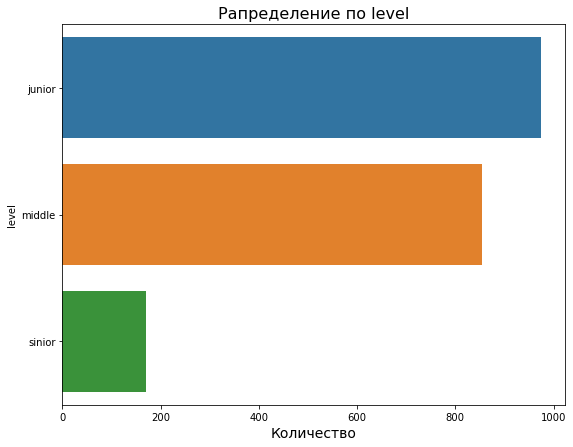

In [32]:
cat_plot(train_job_satisfaction,'level')
display(cat_plot(test_features,'level'))

Ого, скорее всего, компания приличного уровня, так как меньшинство составляет именно sinior с огромным отрывом.

array(['medium', 'high', 'low'], dtype=object)

array(['medium', 'low', 'high', ' '], dtype=object)

None

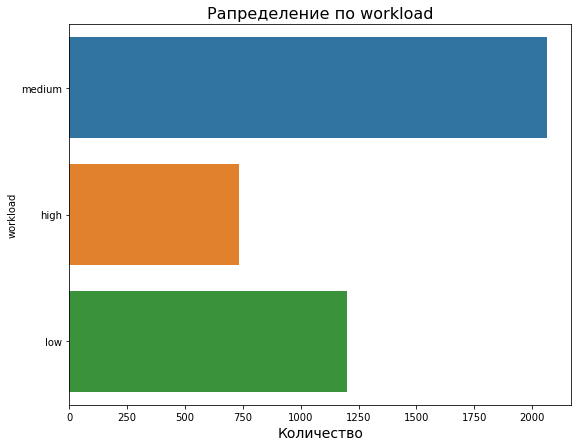

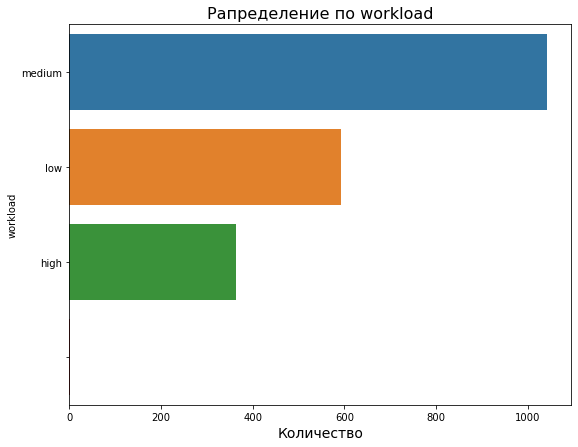

In [33]:
cat_plot(train_job_satisfaction,'workload')
display(cat_plot(test_features,'workload'))

In [34]:
test_features['workload'] = test_features['workload'].replace(' ', np.nan)

In [35]:
test_features['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

In [36]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

Преобладающим ответом является medium. Возможно, в зоне риска располагаются как раз сотрудники с ответом high.

array([ 2,  1,  4,  7,  9,  6,  3, 10,  8,  5], dtype=int64)

array([ 2,  1,  5,  6,  3,  9,  7,  4,  8, 10], dtype=int64)

None

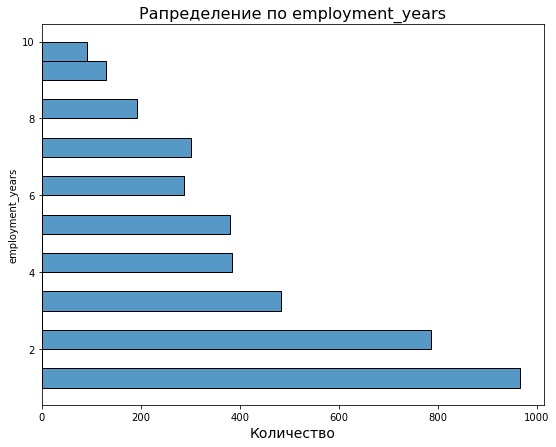

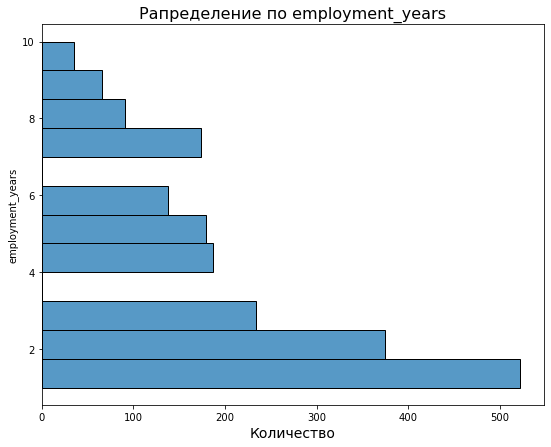

In [37]:
hist_plot(train_job_satisfaction, 'employment_years')
display(hist_plot(test_features, 'employment_years'))

<AxesSubplot:>

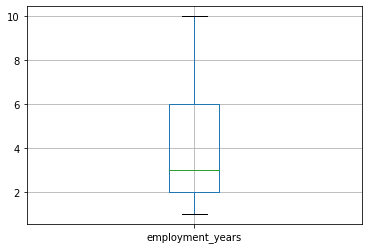

In [38]:
train_job_satisfaction.boxplot(column=['employment_years'])

<AxesSubplot:>

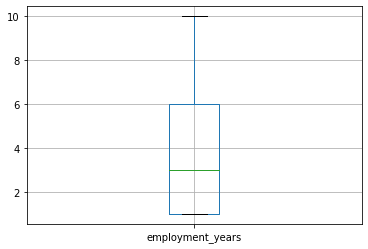

In [39]:
display(test_features.boxplot(column=['employment_years']))

Большинство сотрудников работает в этой компании не так давно. 

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

None

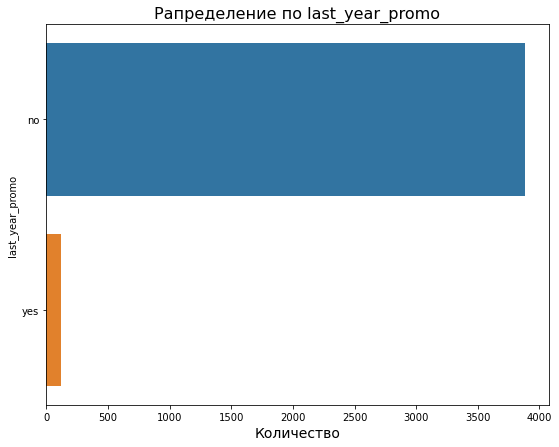

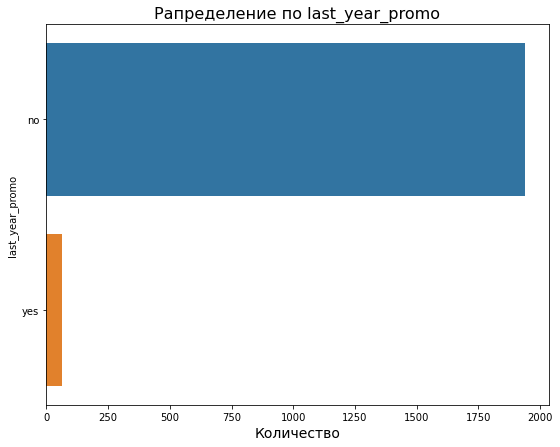

In [40]:
cat_plot(train_job_satisfaction,'last_year_promo')
display(cat_plot(test_features,'last_year_promo'))

Возможно, стоит предложить некоторым сотрудникам повышение, кто подходит на эту роль, разумеется. Нужно будет учесть такой дисбаланс при построении модели. 

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

None

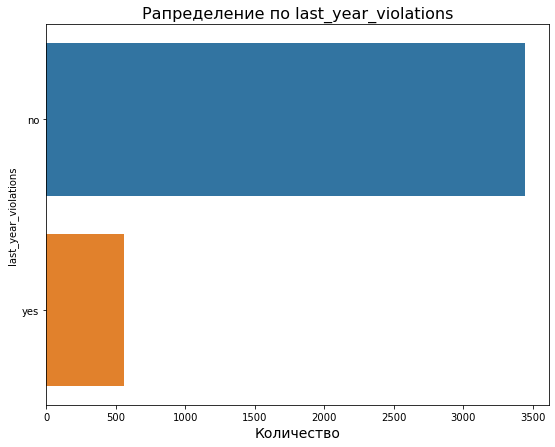

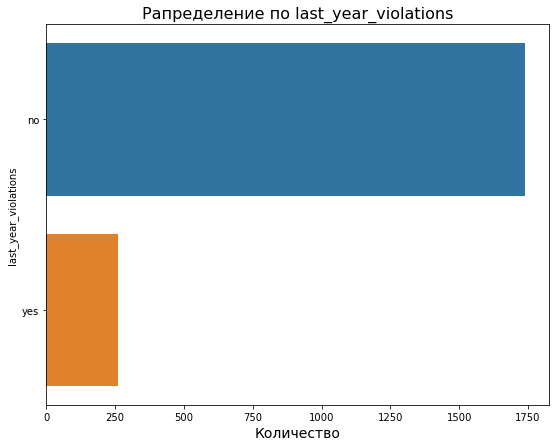

In [41]:
cat_plot(train_job_satisfaction,'last_year_violations')
display(cat_plot(test_features,'last_year_violations'))

О, несмотря на дисбаланс, график радует ответом!

array([1, 5, 2, 3, 4], dtype=int64)

array([5, 4, 3, 1, 2], dtype=int64)

None

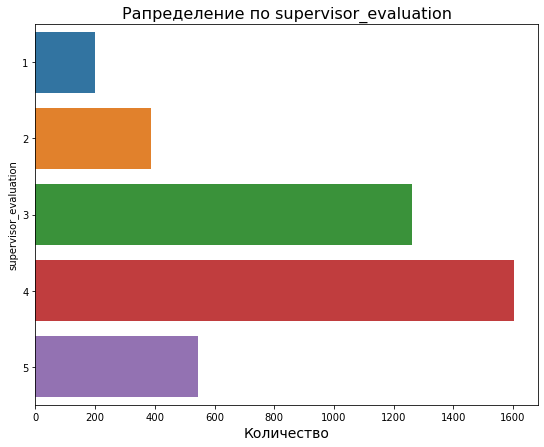

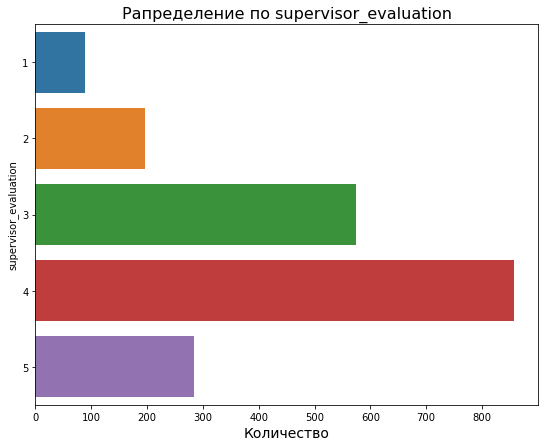

In [42]:
cat_plot(train_job_satisfaction,'supervisor_evaluation')
display(cat_plot(test_features,'supervisor_evaluation'))

<AxesSubplot:>

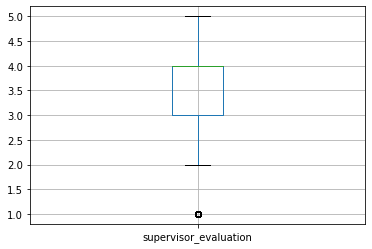

In [43]:
train_job_satisfaction.boxplot(column=['supervisor_evaluation'])

<AxesSubplot:>

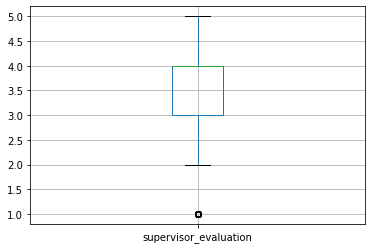

In [44]:
test_features.boxplot(column=['supervisor_evaluation'])

В среднем оценки неплохие. Возможно, у тех, кто получил 1 или 2 нарушали договор? сейчас проверим.

In [45]:
train_job_satisfaction[
    (train_job_satisfaction['supervisor_evaluation']<=2) & 
    (train_job_satisfaction['last_year_violations']=='yes')]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
34,385514,sales,middle,medium,8,no,yes,2,32400,0.23
64,188350,marketing,middle,high,6,no,yes,1,60000,0.31
87,702721,sales,middle,medium,6,no,yes,1,31200,0.15
157,335445,technology,junior,low,1,no,yes,2,21600,0.23
193,493733,sales,junior,medium,1,no,yes,1,26400,0.18
...,...,...,...,...,...,...,...,...,...,...
3954,706200,purchasing,middle,high,10,no,yes,2,51600,0.13
3964,351063,hr,sinior,high,6,no,yes,2,64800,0.16
3972,134106,hr,middle,high,10,no,yes,1,57600,0.39
3978,713279,sales,junior,low,1,no,yes,2,12000,0.09


Хм, видимо, эти признаки не так сильно коррелируют, как казалось изначально. Проверим это позже, когда будем строить матрицу. 

array([24000, 38400, 12000, 18000, 22800, 30000, 56400, 52800, 13200,
       54000, 19200, 40800, 34800, 27600, 26400, 33600, 50400, 15600,
       14400, 25200, 72000, 31200, 32400, 48000, 43200, 46800, 58800,
       84000, 44400, 39600, 37200, 21600, 28800, 62400, 60000, 42000,
       49200, 55200, 57600, 68400, 45600, 51600, 64800, 80400, 20400,
       61200, 76800, 69600, 16800, 36000, 63600, 81600, 66000, 74400,
       67200, 70800, 73200, 75600, 79200, 94800, 78000, 88800, 92400,
       85200, 91200, 98400, 96000, 97200], dtype=int64)

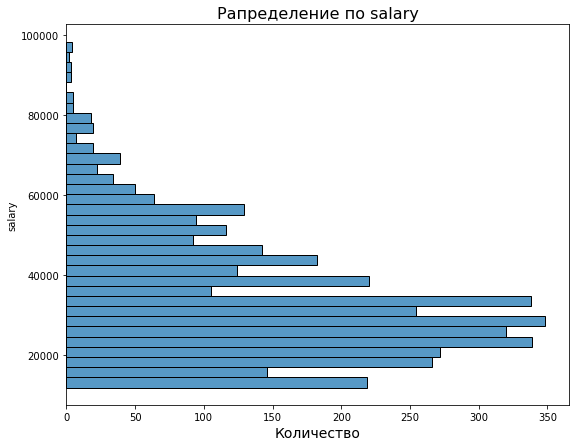

In [47]:
hist_plot(train_job_satisfaction,'salary')

<AxesSubplot:>

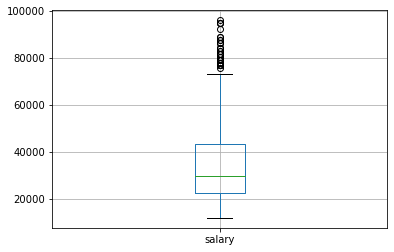

In [48]:
test_features.boxplot(column=['salary'])

<AxesSubplot:>

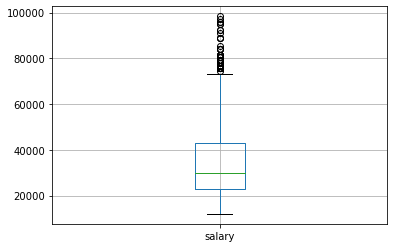

In [49]:
train_job_satisfaction.boxplot(column=['salary'])

Большинство получает около 30000. Возможно, стоит повысить зарплату?...

array([0.58, 0.76, 0.11, 0.37, 0.2 , 0.78, 0.56, 0.44, 0.14, 0.47, 0.74,
       0.42, 0.32, 0.57, 0.16, 0.69, 0.33, 0.64, 0.39, 0.8 , 0.79, 0.17,
       0.65, 0.18, 0.19, 0.49, 0.63, 0.22, 0.23, 0.5 , 0.35, 0.3 , 0.77,
       0.88, 0.59, 0.21, 0.36, 0.85, 0.7 , 0.48, 0.6 , 0.1 , 0.27, 0.71,
       0.86, 0.54, 0.73, 0.46, 0.31, 0.72, 0.51, 0.61, 0.81, 0.99, 0.15,
       0.91, 0.68, 0.4 , 0.89, 0.67, 0.75, 0.98, 0.26, 0.45, 0.92, 0.82,
       0.66, 0.55, 0.38, 0.53, 0.84, 0.52, 0.24, 0.62, 0.41, 0.28, 0.09,
       0.97, 0.83, 0.25, 0.43, 0.04, 0.13, 0.29, 0.95, 0.93, 0.87, 0.08,
       0.94, 0.07, 0.34, 0.9 , 0.12, 0.06, 0.96, 0.05, 1.  , 0.03])

array([0.74, 0.75, 0.6 , 0.72, 0.08, 0.76, 0.64, 0.38, 0.14, 0.59, 0.91,
       0.78, 0.7 , 0.79, 0.34, 0.81, 0.23, 0.4 , 0.58, 0.77, 0.68, 0.24,
       0.42, 0.69, 0.47, 0.35, 0.71, 0.83, 0.61, 0.65, 0.37, 0.45, 0.63,
       0.82, 0.16, 0.89, 0.28, 0.32, 0.88, 0.36, 0.33, 0.31, 0.27, 0.73,
       0.53, 0.26, 0.57, 0.2 , 1.  , 0.56, 0.67, 0.19, 0.52, 0.43, 0.12,
       0.11, 0.21, 0.13, 0.49, 0.22, 0.86, 0.46, 0.41, 0.48, 0.29, 0.87,
       0.66, 0.8 , 0.55, 0.5 , 0.51, 0.62, 0.85, 0.84, 0.15, 0.39, 0.25,
       0.9 , 0.07, 0.1 , 0.92, 0.3 , 0.44, 0.18, 0.93, 0.54, 0.96, 0.09,
       0.99, 0.17, 0.95, 0.06, 0.94, 0.03, 0.98, 0.97, 0.04, 0.05])

None

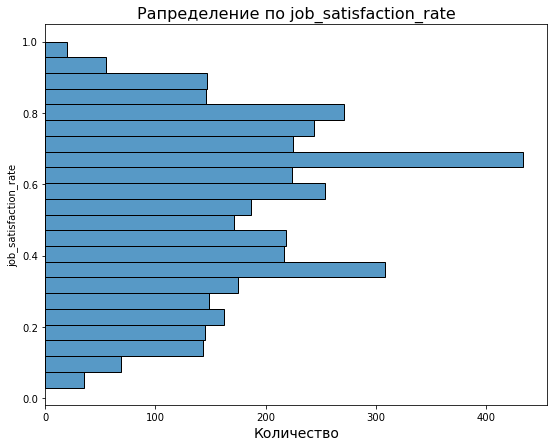

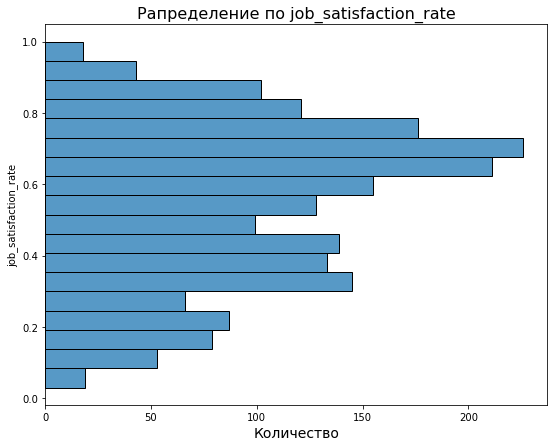

In [50]:
hist_plot(train_job_satisfaction,'job_satisfaction_rate')
display(hist_plot(test_target_job_satisfaction,'job_satisfaction_rate'))

In [51]:
print(train_job_satisfaction['job_satisfaction_rate'].mean())
test_target_job_satisfaction['job_satisfaction_rate'].mean()

0.5339950000000013


0.5487799999999999

<AxesSubplot:>

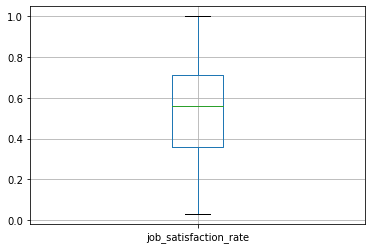

In [52]:
train_job_satisfaction.boxplot(column=['job_satisfaction_rate'])

<AxesSubplot:>

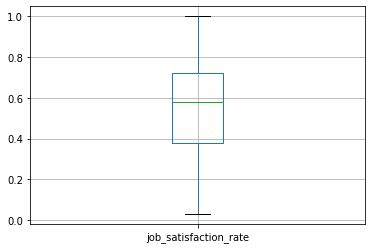

In [53]:
test_target_job_satisfaction.boxplot(column=['job_satisfaction_rate'])

Оценка сотрудников не в критическом состоянии. Это радует!
Но как видими, оценка в целевом датасете выше. 

Посотрим на матирцу корреляции.

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


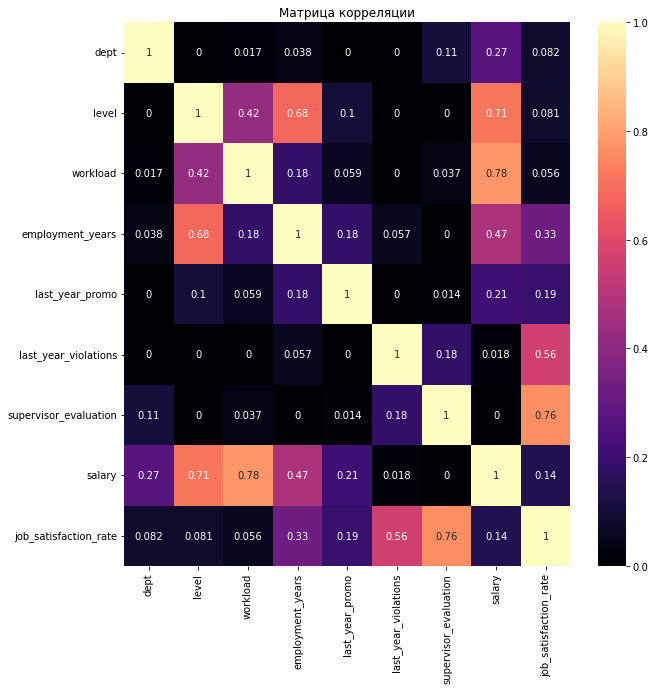

In [54]:
matrix_corr = train_job_satisfaction.drop('id', axis=1).phik_matrix()
plt.figure(figsize=(10, 10))
sns.heatmap(matrix_corr, annot=True, cmap='magma')
plt.title('Матрица корреляции')
plt.show()

interval columns not set, guessing: ['job_satisfaction_rate', 'employment_years', 'supervisor_evaluation', 'salary']


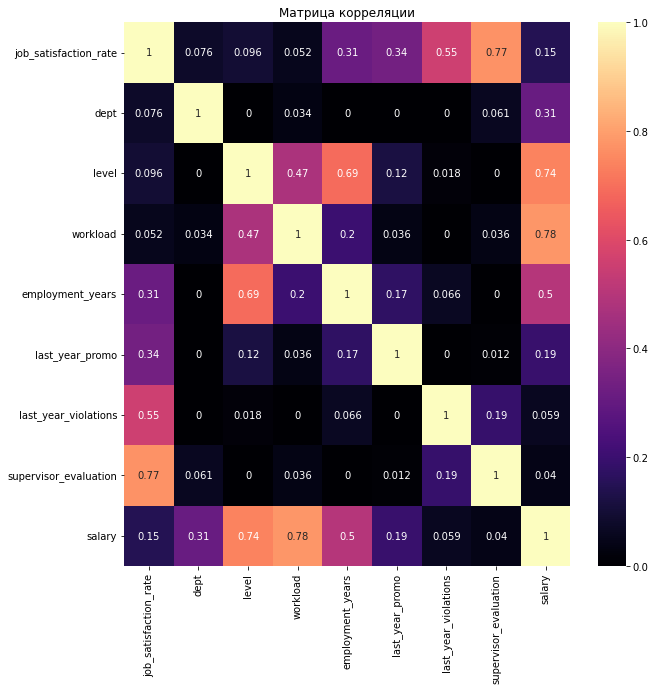

In [55]:
full_test = test_target_job_satisfaction.merge(test_features, on='id', how='left')
matrix_corr = full_test.drop('id', axis=1).phik_matrix()
plt.figure(figsize=(10, 10))
sns.heatmap(matrix_corr, annot=True, cmap='magma')
plt.title('Матрица корреляции')
plt.show()

**Вывод:** в данных в некоторых признаках присутствует дисбаланс. В целом, распределение хорошее, есть некоторые моменты, на которые мы уже указали при анализе. Целевой признак коррелирует с только `supervisor_evaluation`, `last_year_violations`. Необычно, однако. Также датасеты train_job_satisfaction и test_features+test_target_job_satisfaction несильно отличаются, так что модель должна адекватно обучиться в будущем. Также мы обнаружили пробелы в данных, заполнили их значением nan.

## Подготовка данных

In [56]:
full_test.head(10)

,id,job_satisfaction_rate,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,130604,0.74,technology,junior,medium,1,no,no,4,34800
1,825977,0.75,marketing,middle,high,7,no,no,5,58800
2,418490,0.60,purchasing,junior,low,1,no,no,4,19200
3,555320,0.72,technology,junior,medium,1,no,no,4,34800
4,826430,0.08,technology,junior,medium,1,no,yes,2,30000
5,817219,0.76,technology,junior,medium,2,no,no,5,31200
6,269033,0.64,hr,junior,medium,1,no,no,4,27600
7,962356,0.38,technology,middle,high,2,no,no,3,56400
8,649052,0.14,technology,middle,medium,2,no,yes,3,45600
9,532834,0.59,sales,middle,medium,4,no,no,4,38400


In [57]:
full_test.isna().sum()

id                       0
job_satisfaction_rate    0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [58]:
full_test.dropna(inplace=True)
full_test.isna().sum()

id                       0
job_satisfaction_rate    0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [59]:
full_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1995 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1995 non-null   int64  
 1   job_satisfaction_rate  1995 non-null   float64
 2   dept                   1995 non-null   object 
 3   level                  1995 non-null   object 
 4   workload               1995 non-null   object 
 5   employment_years       1995 non-null   int64  
 6   last_year_promo        1995 non-null   object 
 7   last_year_violations   1995 non-null   object 
 8   supervisor_evaluation  1995 non-null   int64  
 9   salary                 1995 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 171.4+ KB


In [60]:
X_train = train_job_satisfaction.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction['job_satisfaction_rate']
X_test = full_test.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = full_test['job_satisfaction_rate']

In [62]:
X_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,sales,junior,medium,2,no,no,1,24000
1,hr,junior,high,2,no,no,5,38400
2,sales,junior,low,1,no,no,2,12000
3,technology,junior,low,4,no,no,2,18000
4,hr,junior,medium,1,no,no,3,22800


In [63]:
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,technology,junior,medium,1,no,no,4,34800
1,marketing,middle,high,7,no,no,5,58800
2,purchasing,junior,low,1,no,no,4,19200
3,technology,junior,medium,1,no,no,4,34800
4,technology,junior,medium,1,no,yes,2,30000


In [64]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [65]:
ohe_pipe = Pipeline(
[
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

In [66]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        
        ('ord',
        OrdinalEncoder(categories=[
            ['junior', 'middle', 'sinior'],
            ['low', 'medium', 'high']],
                       handle_unknown='use_encoded_value',
                       unknown_value=np.nan)
        ),
        
        ('simpleImputer_after_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [67]:
data_preprocessor = ColumnTransformer(
[
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)
],
    remainder='passthrough'
)

In [68]:
pipe_final = Pipeline([
('preprocessor', data_preprocessor),
('models', LinearRegression())
])

In [69]:
param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 20),
        'models__max_features': range(5, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [70]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [71]:
smape_scorer = make_scorer(score_func=smape, greater_is_better=False)

In [72]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring=smape_scorer
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(steps=[...
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [DecisionTreeRegressor(max_depth=13,
                                                           max_features=11,
                                                           random_state=42)],
                          'models__max_depth': range(5, 20),
                          'models__max_features': range(5, 20),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False))

In [73]:
#print('Лучшая модель и её параметры:\n\n',grid_search.best_estimator_)
print ('Метрика SMAPE лучшей модели на тренировочной выборке:', round(grid_search.best_score_*(-1), 2))

Метрика SMAPE лучшей модели на тренировочной выборке: 15.01


Мы получили идентичные параметры.

In [74]:
print(f'Метрика SMAPE лучшей модели на тестовой выборке: {round(smape(y_test, grid_search.best_estimator_.predict(X_test)),2)}')

Метрика SMAPE лучшей модели на тестовой выборке: 14.3


Можно сделать следующие выводы: 
* Лучшей моделью оказалась DecisionTreeRegressor со следующими параметрами max_depth=13, max_features=11.
* Метрика SMAPE лучшей модели на тренировочной выборке составила 15.01.
* Метрика SMAPE лучшей модели на тестовой выборке составила 14.3.

Таким образом, мы обучили модель предсказывать уровень удовлетворённости сотрудника с точностью 14.3/15.00.

# Задача 2: предсказание увольнения сотрудника из компании

## Загрузка данных

In [77]:
train_quit = pd.read_csv(r'~/train_quit.csv')
test_features = pd.read_csv(r'~/test_features.csv')
test_target_quit = pd.read_csv(r'~/test_target_quit.csv')

In [78]:
train_quit.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


In [79]:
train_quit.info()
display(train_quit.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


Данные хорошие, без пропусков. 

In [80]:
test_features.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


In [81]:
test_features.info()
display(test_features.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


Присутстсвуют пропуски в данных.

In [82]:
test_target_quit.head(10)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


In [83]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Данные без пропусков.

**Вывод:** данные чистые, столбцы приведены к змеиному регистру, присутствуют пропуски в датасете test_features, тип данных соответствует нужному.

## Предобработка данных

Данные уже приведены к змеиному регистру, проверим на пропуски еще раз и на дубли.

In [84]:
print('Количество пропусков в train_quit:\n', train_quit.isna().sum())
print()
print('Количество пропусков в test_features:\n', test_features.isna().sum())
print('Количество пропусков в test_target_quit:\n ', test_target_quit.isna().sum())

Количество пропусков в train_quit:
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Количество пропусков в test_features:
 id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
Количество пропусков в test_target_quit:
  id      0
quit    0
dtype: int64


In [85]:
print('Количество дубликатов в train_quit: ', train_quit.duplicated().sum())
print('Количество дубликатов в test_features: ', test_features.duplicated().sum())
print('Количество дубликатов в test_target_quit: ', test_target_quit.duplicated().sum())

Количество дубликатов в train_quit:  0
Количество дубликатов в test_features:  0
Количество дубликатов в test_target_quit:  0


In [86]:
train_quit[train_quit.duplicated(
    subset=['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 
            'last_year_violations', 'supervisor_evaluation','salary', 'quit'])]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
117,873412,technology,junior,medium,2,no,no,4,31200,no
152,749683,sales,middle,low,8,no,no,4,19200,no
175,689526,marketing,middle,low,6,no,no,3,30000,no
205,786443,purchasing,middle,low,6,no,no,4,19200,no
254,362060,sales,junior,low,1,no,no,4,12000,yes
...,...,...,...,...,...,...,...,...,...,...
3990,632886,sales,junior,low,3,no,no,4,12000,no
3993,387733,marketing,middle,medium,5,no,no,3,44400,no
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no


Удручающая ситуация, ничего трогать не будем...

In [87]:
test_features[test_features.duplicated(
    subset=['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 
            'last_year_violations', 'supervisor_evaluation','salary'])]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
30,523542,marketing,junior,low,1,no,no,3,16800
56,582128,sales,middle,high,5,no,no,4,48000
62,482624,technology,middle,medium,4,yes,no,2,44400
111,770429,hr,junior,medium,1,no,no,4,30000
113,761490,sales,junior,low,1,no,no,4,15600
...,...,...,...,...,...,...,...,...,...
1992,760964,sales,junior,medium,3,no,no,5,21600
1993,380255,sales,middle,medium,8,no,no,4,38400
1995,393147,marketing,junior,low,3,no,no,3,20400
1997,305653,technology,junior,low,1,no,no,3,14400


In [88]:
test_features['dept'].value_counts()

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

In [89]:
test_features['workload'].value_counts()

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

In [90]:
test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['workload'] = test_features['workload'].replace(' ', np.nan)

**Вывод:** мы обнаружили пропуски в данных и дубли, которые исправим в пайплайне. 

## Исследовательский анализ данных

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

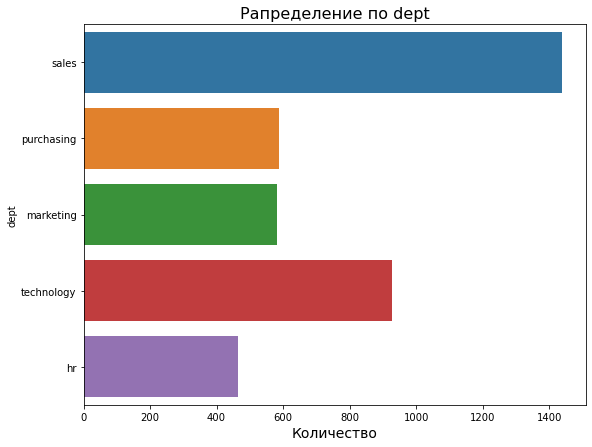

In [91]:
cat_plot(train_quit, 'dept')

Большинство сотрудников из отдела продаж.

array(['middle', 'junior', 'sinior'], dtype=object)

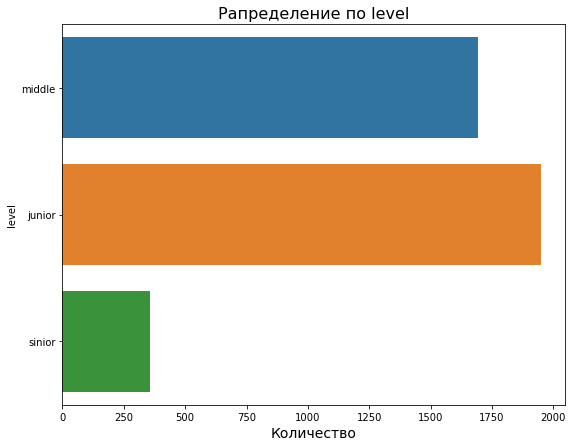

In [92]:
cat_plot(train_quit, 'level')

Преобладает уровень junior. Хороший результат. 

array(['high', 'medium', 'low'], dtype=object)

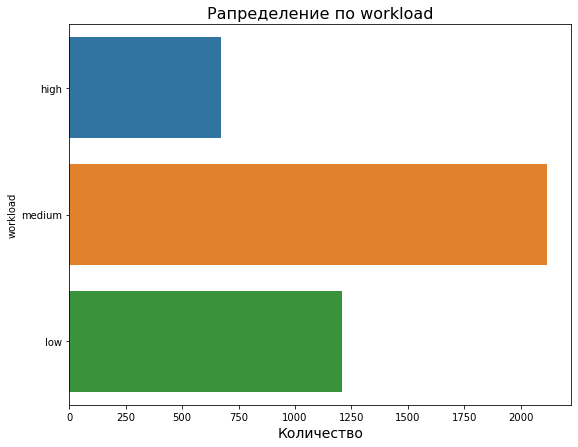

In [93]:
cat_plot(train_quit, 'workload')

Нужно будем рассмотреть отдельно высокую загруженность и среднуюю.

array(['no', 'yes'], dtype=object)

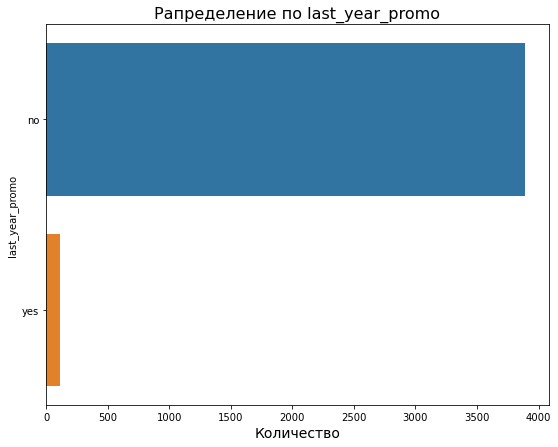

In [94]:
cat_plot(train_quit, 'last_year_promo')

array(['no', 'yes'], dtype=object)

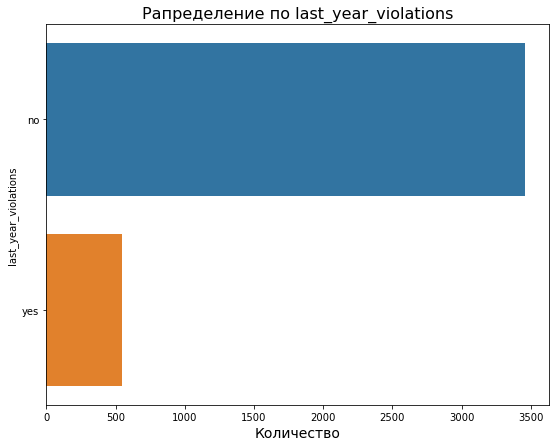

In [95]:
cat_plot(train_quit, 'last_year_violations')

array([ 2,  5,  1,  8,  4,  7,  3,  9,  6, 10], dtype=int64)

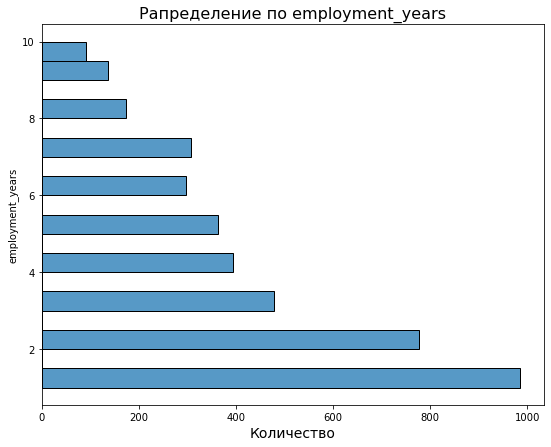

In [96]:
hist_plot(train_quit, 'employment_years')  

array([4, 1, 3, 5, 2], dtype=int64)

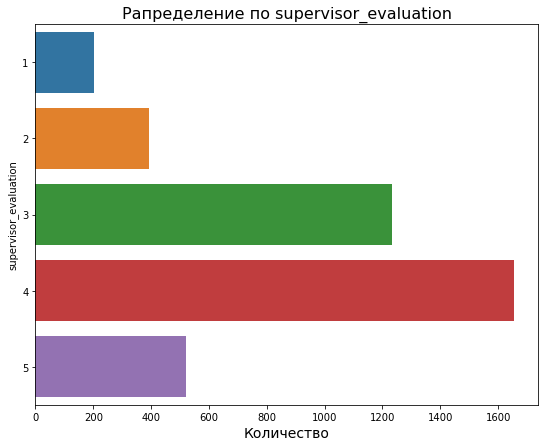

In [97]:
cat_plot(train_quit, 'supervisor_evaluation')

Хм, в теории, неплохие оценки.

array([54000, 27600, 37200, 24000, 25200, 18000, 44400, 19200, 45600,
       57600, 33600, 16800, 22800, 26400, 82800, 32400, 39600, 30000,
       46800, 12000, 15600, 58800, 60000, 66000, 21600, 38400, 62400,
       40800, 56400, 34800, 28800, 52800, 20400, 36000, 61200, 48000,
       43200, 73200, 31200, 78000, 64800, 72000, 94800, 96000, 63600,
       79200, 55200, 42000, 49200, 50400, 14400, 13200, 51600, 67200,
       88800, 68400, 69600, 70800, 84000, 81600, 87600, 75600, 91200,
       76800, 74400, 80400, 85200, 86400, 92400], dtype=int64)

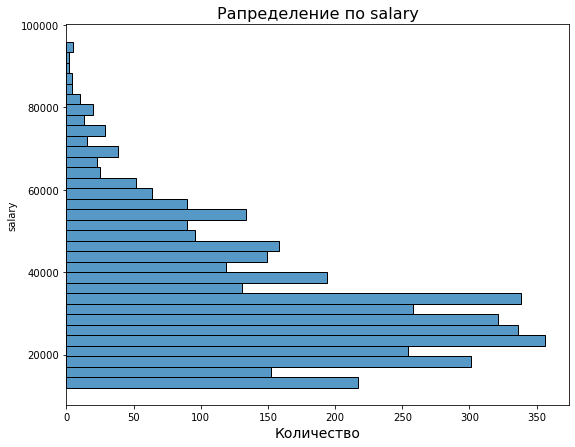

In [98]:
hist_plot(train_quit, 'salary')

Зарплата оставляет желать лучшего.

array(['no', 'yes'], dtype=object)

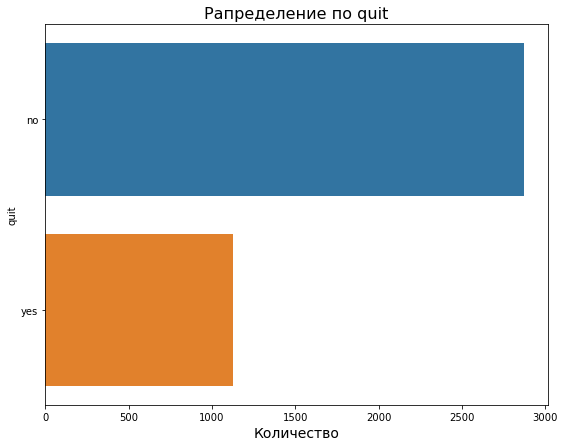

In [99]:
cat_plot(train_quit, 'quit')

Одна треть - впечатляет.

**Рассмотрим отдельно сотрудников, которые покинули компанию.**

Посмотрим на матрицу корреляции.

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary']


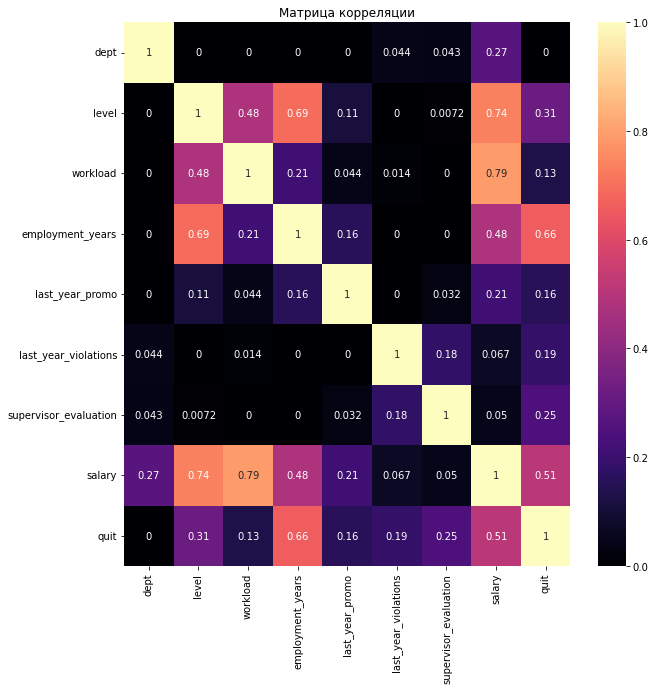

In [100]:
matrix_corr = train_quit.drop('id', axis=1).phik_matrix()
plt.figure(figsize=(10, 10))
sns.heatmap(matrix_corr, annot=True, cmap='magma')
plt.title('Матрица корреляции')
plt.show()

Интересный результат, попробуем рассмотреть поподробнее.

In [102]:
train_quit_yes = train_quit[train_quit['quit'] == 'yes']

In [103]:
train_quit_yes.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes


sales         407
technology    276
purchasing    166
marketing     163
hr            116
Name: dept, dtype: int64


array(['sales', 'technology', 'marketing', 'purchasing', 'hr'],
      dtype=object)

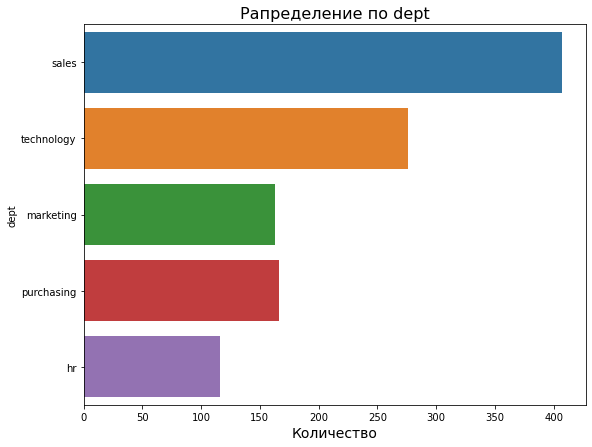

In [104]:
print(train_quit_yes['dept'].value_counts())
cat_plot(train_quit_yes, 'dept')

Большинство уволенных сотрудников работали в sales. 

array(['medium', 'low', 'high'], dtype=object)

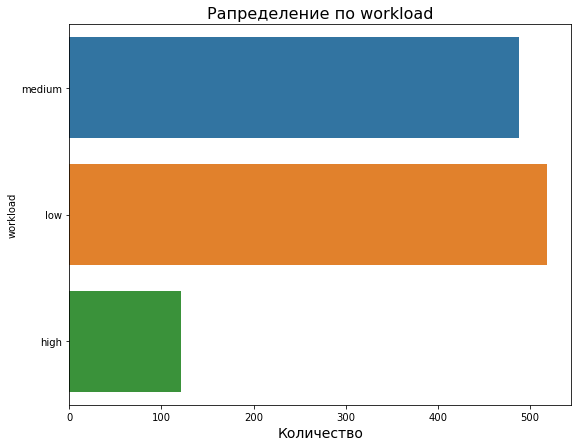

In [105]:
cat_plot(train_quit_yes, 'workload')

Это странно. Было бы понятно, если бы эти сотрудники имели высокую загруженность, тут же совершенно другая картина.

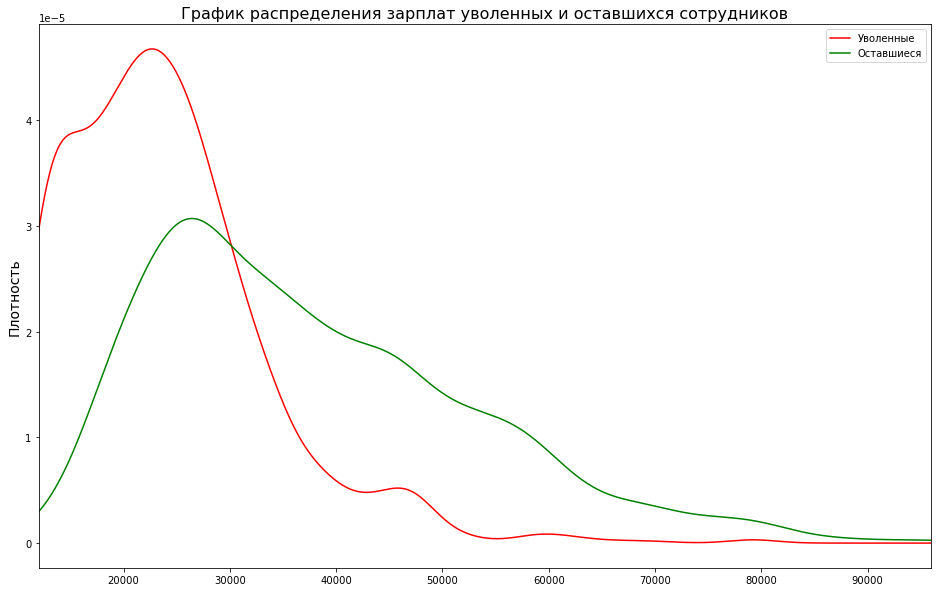

In [106]:
plt.figure(figsize=(16, 10))
plt.title("График распределения зарплат уволенных и оставшихся сотрудников", 
          fontsize=16)
plt.xlim(train_quit['salary'].min(), train_quit['salary'].max())
ax = train_quit['salary'][train_quit['quit'] == 'yes'].plot.kde(color='red', label="Уволенные")
ax = train_quit['salary'][train_quit['quit'] == 'no'].plot.kde(color='green', label="Оставшиеся")
ax.set_ylabel("Плотность", fontsize=14)
plt.legend()
plt.show()

Тут уже все логично. Их могла мотивировать уволиться большая заработная плата в другой компании (например).

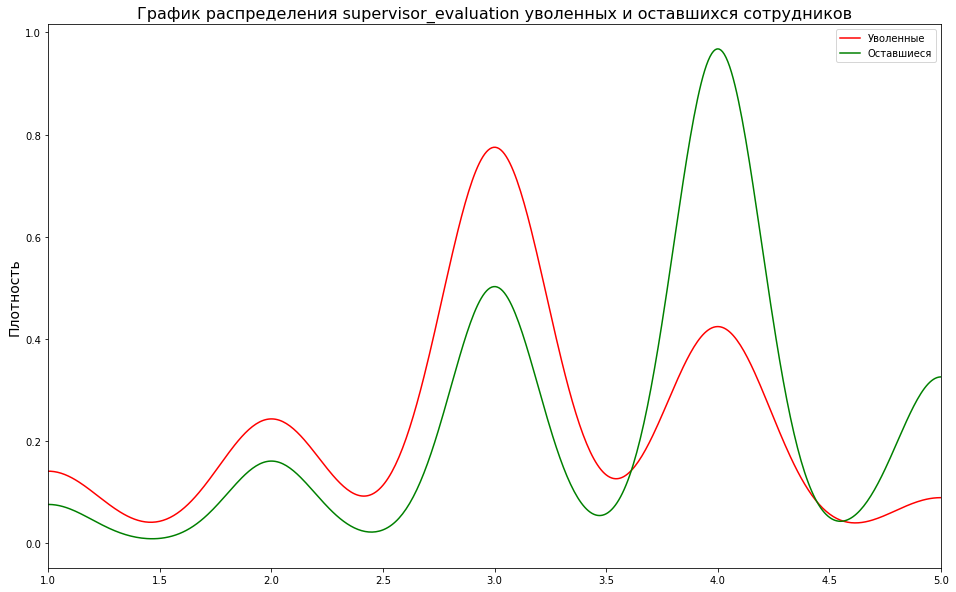

In [108]:
plt.figure(figsize=(16, 10))
plt.title("График распределения supervisor_evaluation уволенных и оставшихся сотрудников", 
          fontsize=16)
plt.xlim(train_quit['supervisor_evaluation'].min(), train_quit['supervisor_evaluation'].max())
ax = train_quit['supervisor_evaluation'][train_quit['quit'] == 'yes'].plot.kde(color='red', label="Уволенные")
ax = train_quit['supervisor_evaluation'][train_quit['quit'] == 'no'].plot.kde(color='green', label="Оставшиеся")
ax.set_ylabel("Плотность", fontsize=14)
plt.legend()
plt.show()

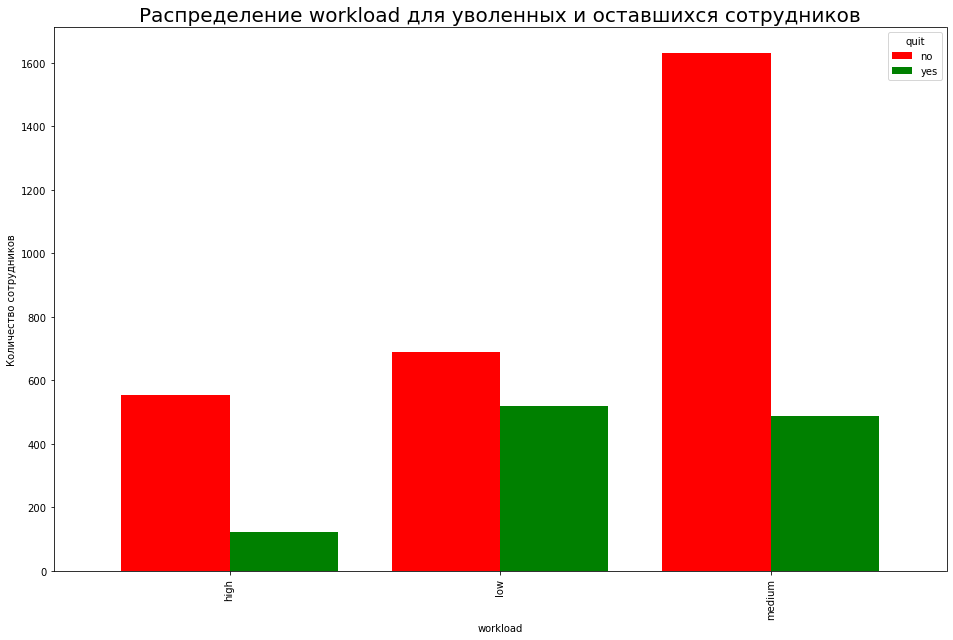

In [110]:
# РЕВЬЮЕР
ax = grouped_data.plot(
    kind='bar', color=['red', 'green'],  figsize=(16,10),  width=0.8,
    legend=True, ylabel='Количество сотрудников',
    title='Распределение workload для уволенных и оставшихся сотрудников',
)
ax.title.set_size(20)
plt.show()

Как видно, покидали компанию большинство сотрудников, которые имели среднюю нагрузку.

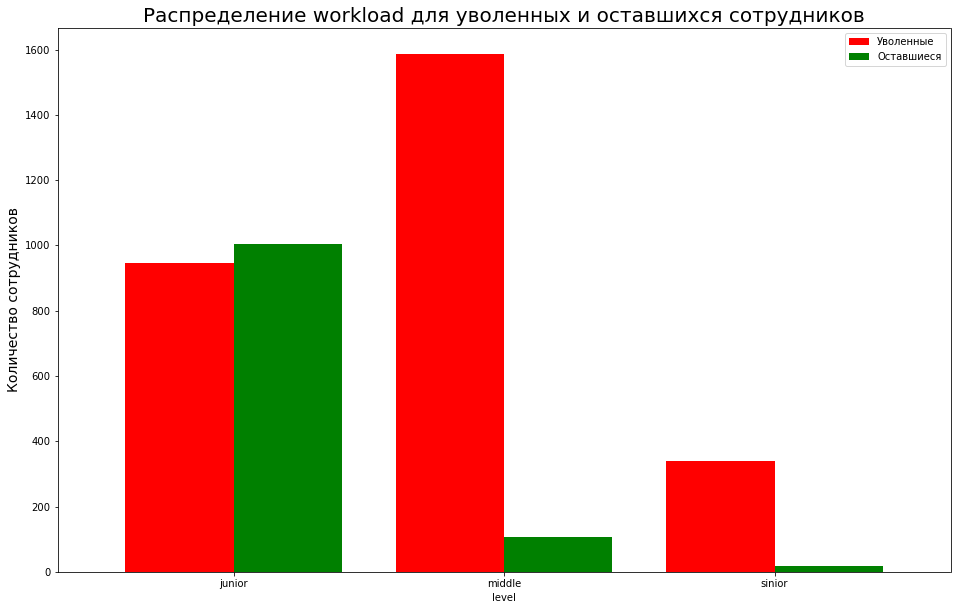

In [112]:
ax = grouped_data.plot(
    kind='bar',
    color=['red', 'green'],
    figsize=(16, 10),
    width=0.8,
    legend=True,
    ylabel='Количество сотрудников',
    title='Распределение workload для уволенных и оставшихся сотрудников',
)

ax.set_title('Распределение workload для уволенных и оставшихся сотрудников', fontsize=20)
ax.set_ylabel('Количество сотрудников', fontsize=14)
ax.tick_params(axis='x', rotation=0)
plt.legend(['Уволенные', 'Оставшиеся'])
plt.show()

Уволившиеся сотрудники имели разный опыт работы, но в основном до 4 лет. Возможно, тут они планировали просто набраться опыта, достигнуть уровнень мидл и перейти в другую компанию.

**Вывод**: большинство сотрудников, покинувших компанию, имели следующие характеристики:
* работали в отделе продаж;
* имели небольшую зарплату;
* покидали компанию после 1-4 лет работы;
* имели среднуюю или низкую загруженность;
* в основном, это middle и junior.

Последний пункт янво напрягает, но, возможно, им было скучно? и/или хотелось чего-то большего? 

## Добавление нового входного признака

Добавим признак job_satisfaction_rate, предсказанный лучшей моделью ранее, к входным признакам датасета train_quit.

In [113]:
train_quit['job_satisfaction_rate'] = grid_search.best_estimator_.predict(train_quit)

In [114]:
test_features['job_satisfaction_rate'] = grid_search.best_estimator_.predict(test_features)

In [116]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.872000
1,686555,hr,junior,medium,1,no,no,4,30000,0.668621
2,467458,sales,middle,low,5,no,no,4,19200,0.657143
3,418655,sales,middle,low,6,no,no,4,19200,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.824127


In [117]:
train_quit.sort_values(by='id')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
2600,100222,sales,junior,medium,3,no,no,2,20400,yes,0.340000
717,100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.333333
2455,100469,marketing,junior,medium,1,no,no,4,28800,no,0.659545
1592,100601,technology,middle,high,4,no,no,4,68400,no,0.667586
2657,100858,sales,junior,medium,2,no,no,4,25200,yes,0.823636
...,...,...,...,...,...,...,...,...,...,...,...
2194,998517,purchasing,middle,low,5,no,no,3,19200,no,0.470000
3701,999003,hr,middle,low,3,no,no,2,24000,yes,0.170000
3364,999158,purchasing,junior,medium,1,no,yes,1,21600,yes,0.060000
18,999835,sales,junior,low,5,no,no,4,18000,no,0.865000


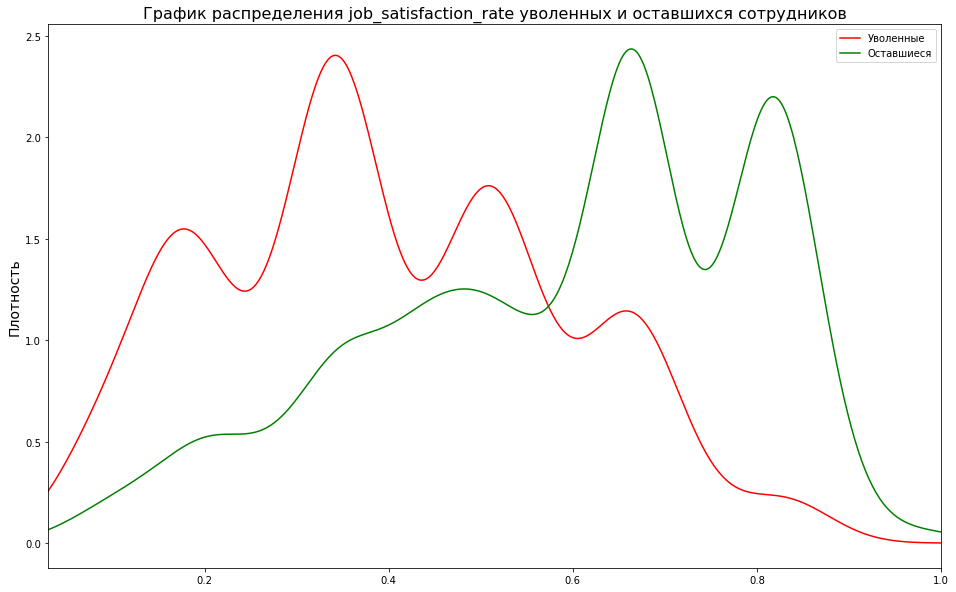

In [118]:
plt.figure(figsize=(16, 10))
plt.title("График распределения job_satisfaction_rate уволенных и оставшихся сотрудников", 
          fontsize=16)
plt.xlim(train_quit['job_satisfaction_rate'].min(), train_quit['job_satisfaction_rate'].max())
ax = train_quit['job_satisfaction_rate'][train_quit['quit'] == 'yes'].plot.kde(color='red', label="Уволенные")
ax = train_quit['job_satisfaction_rate'][train_quit['quit'] == 'no'].plot.kde(color='green', label="Оставшиеся")
ax.set_ylabel("Плотность", fontsize=14)
plt.legend()
plt.show()

**Вывод:** мы добавили входной признак. Как мы видим, уровень удовлетворённости сотрудника работой в компании влияет на принятие его решения.

## Подготовка данных

In [119]:
full_test = test_target_quit.merge(test_features, on='id', how='left')
full_test.head(10)

,id,quit,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,999029,yes,technology,junior,medium,1,no,no,3,31200,0.335000
1,372846,no,sales,middle,medium,10,no,yes,2,32400,0.230000
2,726767,no,marketing,middle,low,7,no,no,4,20400,0.670000
3,490105,no,purchasing,middle,low,7,no,no,4,19200,0.695000
4,416898,yes,purchasing,junior,low,1,no,no,4,12000,0.510000
5,223063,no,sales,middle,medium,6,no,no,4,38400,0.824127
6,810370,no,hr,junior,medium,1,no,no,5,26400,0.688750
7,998900,no,marketing,middle,medium,7,no,no,3,45600,0.438400
8,578329,no,sales,sinior,medium,10,no,no,5,46800,0.752000
9,648850,no,sales,middle,high,9,no,no,5,57600,0.846842


In [120]:
full_test.isna().sum()

id                       0
quit                     0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [121]:
full_test.dropna(inplace=True)
full_test.isna().sum()

id                       0
quit                     0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

**Вывод:** мы подготовили тестовый датасет.

## Обучение модели

In [123]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train = train_quit.drop(['id', 'quit'], axis=1)
y_train = train_quit['quit']

X_test = full_test.drop(['id', 'quit'], axis=1)
y_test = full_test['quit']

In [124]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [125]:
ohe_pipe = Pipeline(
[
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

In [126]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        
        ('ord',
        OrdinalEncoder(categories=[
            ['junior', 'middle', 'sinior'],
            ['low', 'medium', 'high']],
                       handle_unknown='use_encoded_value',
                       unknown_value=np.nan)
        ),
        
        ('simpleImputer_after_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [127]:
data_preprocessor = ColumnTransformer(
[
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)
],
    remainder='passthrough'
)

In [128]:
pipe_final = Pipeline([
('preprocessor', data_preprocessor),
('models', DecisionTreeClassifier())
])

In [129]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
                   
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly')],
        'models__degree': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [130]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(s...
                                        {'models': [RandomForestClassifier(max_depth=10,
                                                                           max_features=2,
                                                                           random_state=42)],
                                         'models__max_depth': range(2, 20),
                                         'models__max_features': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        random_state=42)],
                                         'models__degree': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [131]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

**Вывод:** мы обучили модель, которая предсказала на тренировочной выборке с точносью 0.94,а площадь ROC-кривой составила 0.93. Лучшей моделью оказалась RandomForestClassifier(max_depth=10, max_features=2, random_state=42).

## Общий вывод

В этом исследовании были достигнуты две поставленные задачи:

**1. Предсказание уровня удовлетворённости сотрудника.**

Для ее достижения мы сделали следующие: 
* загрузили и изучили данные.
* провели предобрабодку.
* провели исследовательский анализ данных.
* построили модель для предсказания уровня удовлетворённости сотрудника. Лучшей моделью оказалась DecisionTreeRegressor со следующими параметрами max_depth=13, max_features=11.
* Метрика SMAPE лучшей модели на тренировочной выборке составила 15.01.
* Метрика SMAPE лучшей модели на тестовой выборке составила 14.3.

Таким образом, мы обучили модель предсказывать уровень удовлетворённости сотрудника с точностью 14.3/15.00.

**2. Предсказание увольнения сотрудника из компании.**

Для ее достижения мы сделали следующие: 
* загрузили и изучили данные.
* провели предобрабодку.
* провели исследовательский анализ данных.
* сотавили портрет сотрудника, который может покинуть компанию. Большинство из них работали в отделе продаж, имели небольшую зарплату, покидали компанию после 1-4 лет работы, имели среднюю или низкую загруженность.
* Добавили признак job_satisfaction_rate, предсказанный лучшей моделью, построенной в первой задаче, к входным признакам датасета train_quit.
* Обнаружили, что уровень удовлетворённости сотрудника работой в компании влияет на принятие его решения.
* Построили модель, которая предсказала на тренировочной выборке с точносью 0.94,а площадь ROC-кривой составила 0.93. Лучшей моделью оказалась RandomForestClassifier с параметрами max_depth=10, max_features=2, random_state=42.

Таким образом, видно прямую взаимосвязь между тем, покинет ли сотрудник компанию и его удовлетворённостью работой в этой компании. Судя по анализу, можно повысить зарплату сотрудникам, предложить повышение (заслуженным сотрудникам, разумеется). Возможно, еще стоит поискать какие-нибудь интересные проеты, так как многие уволившиеся сотрудники имели низкую занятность. Можно как-нибудь оптимизировать работу: предложить удаленку или провести опрос среди сотрудников. Например, как можно улучшить рабочую обстановку. Так ка мы посмотрели среднуюю оценку удовлетворённости (она состовляет 0.54), думаю, ее стоит повысить, чтобы не рисковать ресурсами.